# B.1.1.529 variant analysis

The B.1.1.529 (AKA omicron) has raised concerns due to its high number of mutations combining mutations from the alpha and delta lineages with new mutations.

Here we aim at understanding its potential impact in an escape from the immunity from the vaccine and from previous strains.

## B.1.1.529 spike protein sequence

Unfortunately, we do not have access to GISAID now, but we have the list of mutations in the spike protein from a reliable source.

From here https://github.com/cov-lineages/pango-designation/issues/343 we fetch the mutations in the spike protein.

A67V, Δ69-70, T95I, G142D/Δ143-145, Δ211/L212I, ins214EPE, G339D, S371L, S373P, S375F, K417N, N440K, G446S, S477N, T478K, E484A, Q493K, G496S, Q498R, N501Y, Y505H, T547K, D614G, H655Y, N679K, P681H, N764K, D796Y, N856K, Q954H, N969K, L981F

We obtain the sequence of spike protein in the omicron lineage by applying these mutations to the reference genome.

In [92]:
from Bio import SeqIO, Align
from Bio.Seq import Seq, IUPAC
from Bio.Alphabet import ProteinAlphabet
from logzero import logger
import pandas as pd
import requests
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("notebook")
import numpy as np
sns.set_style("whitegrid")
sns.color_palette("colorblind")
import time

In [2]:
reference_fasta = "../../references/Sars_cov_2.ASM985889v3.cds.all.fa"
spike_dna = None
for record in SeqIO.parse(reference_fasta, "fasta"):
    if "gene_symbol:S" in record.description:
        spike_dna = record
print(spike_dna.seq)

ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAA

In [3]:
spike_protein = spike_dna.translate()
print(spike_protein.seq)

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGR

In [4]:
omicron_mutations = [
    (67, "A", "V"),             #A67V
    (69, "HV", ""),             #Δ69-70, 
    (95, "T", "I"),             #T95I, 
    (142, "G", "D"),            #G142D
    (143, "VYY", ""),           #Δ143-145, 
    (211, "N", ""),             #Δ211
    (212, "L", "I"),            #L212I, 
    (214, "", "EPE"),           #ins214EPE, 
    (339, "G", "D"),            #G339D, 
    (371, "S", "L"),            #S371L, 
    (373, "S", "P"),            #S373P, 
    (375, "S", "F"),            #S375F, 
    (417, "K", "N"),            #K417N, 
    (440, "N", "K"),            #N440K, 
    (446, "G", "S"),            #G446S, 
    (477, "S", "N"),            #S477N, 
    (478, "T", "K"),            #T478K, 
    (484, "E", "A"),            #E484A, 
    (493, "Q", "K"),            #Q493K, 
    (496, "G", "S"),            #G496S, 
    (498, "Q", "R"),            #Q498R, 
    (501, "N", "Y"),            #N501Y, 
    (505, "Y", "H"),            #Y505H, 
    (547, "T", "K"),            #T547K, 
    (614, "D", "G"),            #D614G, 
    (655, "H", "Y"),            #H655Y,
    (679, "N", "K"),            #N679K, 
    (681, "P", "H"),            #P681H, 
    (764, "N", "K"),            #N764K, 
    (796, "D", "Y"),            #D796Y, 
    (856, "N", "K"),            #N856K, 
    (954, "Q", "H"),            #Q954H, 
    (969, "N", "K"),            #N969K, 
    (981, "L", "F")             #L981F
]

def apply_mutation(sequence, position, reference, alternate):
    logger.info("Applying mutation {}:{}>{}".format(position, reference, alternate))
    if len(reference) == 1 and len(alternate) == 1:
        ## SNV
        assert reference == sequence[position - 1], "Not matching to reference"
        return sequence[0:position - 1] + alternate + sequence[position:], 0
    if len(alternate) == 0:
        ## deletion
        assert reference == str(sequence[position - 1: position - 1 + len(reference)].seq), "Not matching to reference"
        return sequence[0:position - 1] + alternate + sequence[position + len(reference) - 1 : ], - len(reference)
    if len(reference) == 0:
        ## insertion
        return sequence[0:position - 1] + alternate + sequence[position - 1 : ], len(alternate)

def apply_mutations(protein, mutations):
    offset = 0
    for p, r, a in mutations:
        protein, mutation_offset = apply_mutation(protein, position=p + offset, reference=r, alternate=a)
        offset = offset + mutation_offset
    return protein

In [5]:
omicron_apike_protein = apply_mutations(protein=spike_protein, mutations=omicron_mutations)
print(omicron_apike_protein.seq)

[I 211126 23:45:59 157718992:39] Applying mutation 67:A>V
[I 211126 23:45:59 157718992:39] Applying mutation 69:HV>
[I 211126 23:45:59 157718992:39] Applying mutation 93:T>I
[I 211126 23:45:59 157718992:39] Applying mutation 140:G>D
[I 211126 23:45:59 157718992:39] Applying mutation 141:VYY>
[I 211126 23:45:59 157718992:39] Applying mutation 206:N>
[I 211126 23:45:59 157718992:39] Applying mutation 206:L>I
[I 211126 23:45:59 157718992:39] Applying mutation 208:>EPE
[I 211126 23:45:59 157718992:39] Applying mutation 336:G>D
[I 211126 23:45:59 157718992:39] Applying mutation 368:S>L
[I 211126 23:45:59 157718992:39] Applying mutation 370:S>P
[I 211126 23:45:59 157718992:39] Applying mutation 372:S>F
[I 211126 23:45:59 157718992:39] Applying mutation 414:K>N
[I 211126 23:45:59 157718992:39] Applying mutation 437:N>K
[I 211126 23:45:59 157718992:39] Applying mutation 443:G>S
[I 211126 23:45:59 157718992:39] Applying mutation 474:S>N
[I 211126 23:45:59 157718992:39] Applying mutation 475:T>K

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHVISGTNGTKRFDNPVLPFNDGVYFASIEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPIIVEPERDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLKSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLKGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFKGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNHNAQALNTLVKQLSSKFGAISSVLNDIFSRLDKVEAEVQIDRLITGRLQS

## Epitopes

Given the two spike protein sequences we aim at understanding how the set of epitopes from each of these proteins may be recognised differently by the immune system.

We download from IEDB 1502 linear epitopes from SARS-CoV-2 spike glycoprotein with positive outcome for T-cell or MHC binding on 26/11/2021. Of these only 1500 have an exact match with the reference; but only 1437 have an exact match with the B.1.1.529 spike protein. For the remaining 64 epitopes without an exact match in B.1.1.529 we perform a global alignment and fetch the closest sequences.

In [32]:
epitopes = pd.read_csv("epitope_table_export_1637963222.csv", sep=",", skiprows=1)
epitopes = epitopes[epitopes["Object Type"] == "Linear peptide"]
epitopes["epitope"] = epitopes.Description.transform(lambda e: e.split(" ")[0])
epitopes.head()

,Epitope IRI,Object Type,Description,Epitope Modified Residue(s),Epitope Modification(s),Starting Position,Ending Position,Non-peptidic epitope IRI,Epitope Synonyms,Antigen Name,...,Synonyms,Antigen Name.1,Antigen IRI.1,Parent Protein.1,Parent Protein IRI.1,Organism Name.1,Organism IRI.1,Parent Organism.1,Parent Organism IRI.1,epitope
0,http://www.iedb.org/epitope/1220,Linear peptide,AEVQIDRLI,NaN,NaN,989.0,997.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AEVQIDRLI
1,http://www.iedb.org/epitope/2801,Linear peptide,ALNTLVKQL,NaN,NaN,958.0,966.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALNTLVKQL
2,http://www.iedb.org/epitope/3589,Linear peptide,APHGVVFLHV,NaN,NaN,1056.0,1065.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APHGVVFLHV
3,http://www.iedb.org/epitope/6668,Linear peptide,CMTSCCSCLK,NaN,NaN,1236.0,1245.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CMTSCCSCLK
4,http://www.iedb.org/epitope/7247,Linear peptide,CVADYSVLY,NaN,NaN,361.0,369.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CVADYSVLY


In [33]:
epitopes.shape

(1502, 34)

In [34]:
def get_alignment(sequence, epitope):
    alignment = None
    aligner = Align.PairwiseAligner()
    aligner.mode = 'global'
    aligner.match = 2
    aligner.mismatch = -2
    aligner.open_gap_score = -3
    aligner.extend_gap_score = -1
    aligner.target_end_gap_score = 0.0
    aligner.query_end_gap_score = 0.0
    try:
        alignment = aligner.align(sequence, epitope)
    except ValueError as e:
        logger.error(epitope)
        logger.error(e)
    return alignment


def has_exact_match(sequence, epitope):
    exact_match = False
    alignments = get_alignment(sequence=sequence, epitope=epitope)
    if alignments is not None:
        alignment = alignments[0]
        exact_match = len(alignment.aligned[1]) == 1
        #logger.info(alignment.aligned[0])
        #logger.info(alignment.aligned[1])
    return exact_match


def get_closest_match(sequence, epitope):
    alignments = get_alignment(sequence=sequence, epitope=epitope)
    if alignments is not None:
        alignment = alignments[0]
        start, _ = min(alignment.aligned[0])
        _, end = max(alignment.aligned[0])
    return str(sequence[start:end])
        

In [35]:
epitopes["has_exact_match_reference"] = epitopes.epitope.transform(lambda e: has_exact_match(sequence=spike_protein.seq[0:-1], epitope=e))
epitopes["has_exact_match_omicron"] = epitopes.epitope.transform(lambda e: has_exact_match(sequence=omicron_apike_protein.seq[0:-1], epitope=e))

In [36]:
epitopes.has_exact_match_reference.sum()

1500

In [37]:
epitopes.has_exact_match_omicron.sum()

1437

In [38]:
omicron_epitopes = epitopes[(~epitopes.has_exact_match_omicron) & (epitopes.has_exact_match_reference)]
omicron_epitopes.shape

(64, 36)

In [40]:
omicron_epitopes["omicron_closest_epitope"] = omicron_epitopes.epitope.transform(lambda e: get_closest_match(sequence=omicron_apike_protein.seq[0:-1], epitope=e))
omicron_epitopes[["epitope", "omicron_closest_epitope"]].head(10)

,epitope,omicron_closest_epitope
78,SKHTPINLVRDLPQG,SKHTPIIVEPERDLPQG
124,KVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYV,KVCEFQFCNDPFLDHKNNKSWMESEFRVYSSANNCTFEYV
136,NLDSKVGGNY,NKLDSKVSGNY
155,TPINLVRDL,TPIIVEPERDL
208,KHTPINLVRDLPQGF,KHTPIIVEPERDLPQGF
229,VNFNFNGLT,VNFNFNGLKGT
250,FKIYSKHTPINLVRD,FKIYSKHTPIIVEPERD
276,LGVYYHKNNKSWMES,LDHKNNKSWMES
284,LPFFSNVTWFHAIHV,LPFFSNVTWFHV
296,NVTWFHAIHVSGTNG,NVTWFHVISGTNG


## Differential MHC I binding

Using NetMHCpan through IEDB tools we calculate the differential MHC binding between epitopes present in the reference spike protein and epitopes in B.1.1.529.

We use the top 5 HLA alleles in Europe fetched from http://www.allelefrequencies.net/top10freqsc.asp.

In [93]:
def get_mhc_binding(epitope, hla_allele='HLA-A*01:01', length=9):
    retries = 0
    success = False
    while not success and retries < 5:
        response = requests.post("http://tools-cluster-interface.iedb.org/tools_api/mhci/", 
                                 data = {'method':'netmhcpan-4.0', 'sequence_text':epitope, 'allele':hla_allele, 'length':length})
        retries += 1
        success = response.status_code == 200
        if not success:
            time.sleep(2)
    return pd.read_csv(StringIO(response.text), sep="\t")

In [42]:
get_mhc_binding(epitope="SLYNTVATLYCVHQRIDV")

,allele,seq_num,start,end,length,peptide,core,icore,ic50,percentile_rank
0,HLA-A*01:01,1,2,10,9,LYNTVATLY,LYNTVATLY,LYNTVATLY,7394.5,2.1
1,HLA-A*01:01,1,4,12,9,NTVATLYCV,NTVATLYCV,NTVATLYCV,13340.6,4.0
2,HLA-A*01:01,1,5,13,9,TVATLYCVH,TVATLYCVH,TVATLYCVH,21923.4,9.4
3,HLA-A*01:01,1,8,16,9,TLYCVHQRI,TLYCVHQRI,TLYCVHQRI,25612.2,15.0
4,HLA-A*01:01,1,3,11,9,YNTVATLYC,YNTVATLYC,YNTVATLYC,26967.3,17.0
5,HLA-A*01:01,1,7,15,9,ATLYCVHQR,ATLYCVHQR,ATLYCVHQR,27066.7,17.0
6,HLA-A*01:01,1,1,9,9,SLYNTVATL,SLYNTVATL,SLYNTVATL,29795.0,23.0
7,HLA-A*01:01,1,6,14,9,VATLYCVHQ,VATLYCVHQ,VATLYCVHQ,35886.2,43.0
8,HLA-A*01:01,1,10,18,9,YCVHQRIDV,YCVHQRIDV,YCVHQRIDV,37475.1,51.0
9,HLA-A*01:01,1,9,17,9,LYCVHQRID,LYCVHQRID,LYCVHQRID,45449.6,96.0


In [101]:
# run MHC binding on reference epitopes
omicron_epitopes["epitope_mhc_binding_hlaA_01_01"] = omicron_epitopes.epitope.transform(lambda e: get_mhc_binding(epitope=e, hla_allele='HLA-A*01:01'))
omicron_epitopes["epitope_mhc_binding_hlaA_02_01"] = omicron_epitopes.epitope.transform(lambda e: get_mhc_binding(epitope=e, hla_allele='HLA-A*02:01'))
omicron_epitopes["epitope_mhc_binding_hlaA_03_01"] = omicron_epitopes.epitope.transform(lambda e: get_mhc_binding(epitope=e, hla_allele='HLA-A*03:01'))
omicron_epitopes["epitope_mhc_binding_hlaA_11_01"] = omicron_epitopes.epitope.transform(lambda e: get_mhc_binding(epitope=e, hla_allele='HLA-A*11:01'))
omicron_epitopes["epitope_mhc_binding_hlaA_24_02"] = omicron_epitopes.epitope.transform(lambda e: get_mhc_binding(epitope=e, hla_allele='HLA-A*24:02'))

In [112]:
# run MHC binding on omicron epitopes
omicron_epitopes["omicron_closest_epitope_mhc_binding_hlaA_01_01"] = omicron_epitopes.omicron_closest_epitope.transform(lambda e: get_mhc_binding(epitope=e, hla_allele='HLA-A*01:01'))
omicron_epitopes["omicron_closest_epitope_mhc_binding_hlaA_02_01"] = omicron_epitopes.omicron_closest_epitope.transform(lambda e: get_mhc_binding(epitope=e, hla_allele='HLA-A*02:01'))
omicron_epitopes["omicron_closest_epitope_mhc_binding_hlaA_03_01"] = omicron_epitopes.omicron_closest_epitope.transform(lambda e: get_mhc_binding(epitope=e, hla_allele='HLA-A*03:01'))
omicron_epitopes["omicron_closest_epitope_mhc_binding_hlaA_11_01"] = omicron_epitopes.omicron_closest_epitope.transform(lambda e: get_mhc_binding(epitope=e, hla_allele='HLA-A*11:01'))
omicron_epitopes["omicron_closest_epitope_mhc_binding_hlaA_24_02"] = omicron_epitopes.omicron_closest_epitope.transform(lambda e: get_mhc_binding(epitope=e, hla_allele='HLA-A*24:02'))

In [113]:
def extract_netmhcpan_results(suffix):
    omicron_epitopes["best_ic50_{}".format(suffix)] = omicron_epitopes["epitope_mhc_binding_{}".format(suffix)].transform(
        lambda x: x["ic50"].iloc[0] if "ic50" in x.columns else None)
    omicron_epitopes["best_peptide_{}".format(suffix)] = omicron_epitopes["epitope_mhc_binding_{}".format(suffix)].transform(
        lambda x: x["peptide"].iloc[0] if "peptide" in x.columns else None)
    omicron_epitopes["omicron_best_ic50_{}".format(suffix)] = omicron_epitopes["omicron_closest_epitope_mhc_binding_{}".format(suffix)].transform(
        lambda x: x["ic50"].iloc[0] if "ic50" in x.columns else None)
    omicron_epitopes["omicron_best_peptide_{}".format(suffix)] = omicron_epitopes["omicron_closest_epitope_mhc_binding_{}".format(suffix)].transform(
        lambda x: x["peptide"].iloc[0] if "peptide" in x.columns else None)
    
extract_netmhcpan_results(suffix="hlaA_01_01")
extract_netmhcpan_results(suffix="hlaA_02_01")
extract_netmhcpan_results(suffix="hlaA_03_01")
extract_netmhcpan_results(suffix="hlaA_11_01")
extract_netmhcpan_results(suffix="hlaA_24_02")

In [114]:
omicron_epitopes[["epitope", "best_peptide_hlaA_01_01", "best_ic50_hlaA_01_01", 
                  "omicron_closest_epitope", "omicron_best_peptide_hlaA_01_01", "omicron_best_ic50_hlaA_01_01"]].sort_values("best_ic50_hlaA_01_01").head(20)

,epitope,best_peptide_hlaA_01_01,best_ic50_hlaA_01_01,omicron_closest_epitope,omicron_best_peptide_hlaA_01_01,omicron_best_ic50_hlaA_01_01
676,FQFCNDPFLGVYYH,CNDPFLGVY,170.8,FQFCNDPFLDH,FQFCNDPFL,20194.3
664,FCNDPFLGVYYH,CNDPFLGVY,170.8,FCNDPFLDH,FCNDPFLDH,24798.2
663,FCNDPFLGVYYH,CNDPFLGVY,170.8,FCNDPFLDH,FCNDPFLDH,24798.2
623,EFQFCNDPFLGVYYHKN,CNDPFLGVY,170.8,EFQFCNDPFLDHKN,CNDPFLDHK,13791.7
622,EFQFCNDPFLGVYYHKN,CNDPFLGVY,170.8,EFQFCNDPFLDHKN,CNDPFLDHK,13791.7
621,EFQFCNDPFLGVYYHK,CNDPFLGVY,170.8,EFQFCNDPFLDHK,CNDPFLDHK,13791.7
620,EFQFCNDPFLGVYYHK,CNDPFLGVY,170.8,EFQFCNDPFLDHK,CNDPFLDHK,13791.7
619,EFQFCNDPFLGVYYH,CNDPFLGVY,170.8,EFQFCNDPFLDH,FQFCNDPFL,20194.3
618,EFQFCNDPFLGVYYH,CNDPFLGVY,170.8,EFQFCNDPFLDH,FQFCNDPFL,20194.3
1398,FQFCNDPFLGVYYHKNNK,CNDPFLGVY,170.8,FQFCNDPFLDHKNNK,CNDPFLDHK,13791.7


Text(0, 0.5, 'best IC50 B.1.1.529')

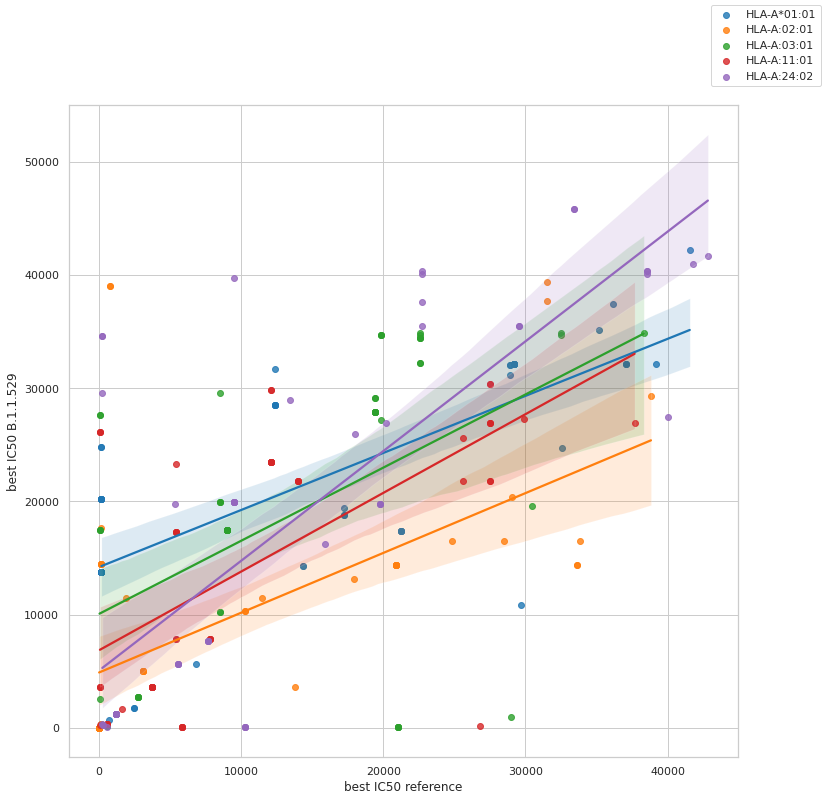

In [125]:
fig = plt.figure(figsize=(12,12))
sns.regplot(data=omicron_epitopes, x="best_ic50_hlaA_01_01", y="omicron_best_ic50_hlaA_01_01", label="HLA-A*01:01")
sns.regplot(data=omicron_epitopes, x="best_ic50_hlaA_02_01", y="omicron_best_ic50_hlaA_02_01", label="HLA-A:02:01")
sns.regplot(data=omicron_epitopes, x="best_ic50_hlaA_03_01", y="omicron_best_ic50_hlaA_03_01", label="HLA-A:03:01")
sns.regplot(data=omicron_epitopes, x="best_ic50_hlaA_11_01", y="omicron_best_ic50_hlaA_11_01", label="HLA-A:11:01")
sns.regplot(data=omicron_epitopes, x="best_ic50_hlaA_24_02", y="omicron_best_ic50_hlaA_24_02", label="HLA-A:24:02")
fig.legend()
plt.xlabel("best IC50 reference")
plt.ylabel("best IC50 B.1.1.529")

In [127]:
omicron_epitopes.to_csv("omicron_epitopes.csv", index=False)